# Malmo Project Few-Shot Learning

Guide: https://huggingface.co/blog/setfit

Requires Python 3.7+

`pip install notebook seaborn pandas datasets setfit sentence-transformers torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116`

In [14]:
import pandas as pd
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer
import torch

In [15]:
# checking for gpu
torch.cuda.is_available()

True

In [16]:
# reading csv files train and test
dtypes = {"text": str, "label": "int8"}
train_df = pd.read_csv("train.csv", dtype=dtypes)
test_df = pd.read_csv("test.csv", dtype=dtypes)
train_df.sample(5)

,text,label
8,Reach the horse,2
7,Don't open the chest,1
1,Get something from the chest,0
6,Get plants,1
9,Go to the horse,2


In [17]:
# loading pretrained model as guide
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")
model

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


SetFitModel()

In [18]:
# loading own dataset instead of the one in the guide
data_files = {"train": "train.csv", "test": "test.csv"}
dataset = load_dataset("csv", data_files=data_files)
dataset

Extracting data files: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 333.32it/s]


Dataset csv downloaded and prepared to C:/Users/shah_/.cache/huggingface/datasets/csv/default-110e1c317e44e276/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 76.92it/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 12
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 11
    })
})

In [19]:
# building trainer as guide shows
trainer = SetFitTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    loss_class=CosineSimilarityLoss,
    batch_size=4,
    num_iterations=20, # Number of text pairs to generate for contrastive learning
    num_epochs=1 # Number of epochs to use for contrastive learning
)

In [20]:
# training and getting metrics as shows on guide(just accuracy, I guess)
trainer.train()
metrics = trainer.evaluate()
metrics

***** Running training *****
  Num examples = 480
  Num epochs = 1
  Total optimization steps = 120
  Total train batch size = 4
Iteration:  52%|████████████████████████████████████▊                                 | 63/120 [00:09<00:08,  6.74it/s]


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.83s/it]
***** Running evaluation *****


{'accuracy': 0.7272727272727273}

In [21]:
# Test/New Instance Results
df = pd.read_csv("test.csv")
instances = df["text"].to_list()
df["pred"] = model(instances)
df["prob"] = torch.max(model.predict_proba(instances), axis=1).values
df

,text,label,pred,prob
0,Get me item from storage,0,0,0.806165
1,Retrieve an item,0,0,0.744045
2,Interact with the chest,0,0,0.941947
3,Open that storage and get me something,0,0,0.736200
4,Get me an item from nature,1,0,0.700774
5,Break an item,1,0,0.529477
6,Break that plant,1,1,0.934219
7,Remove plant,1,1,0.927302
8,Extract plant,1,1,0.897149
9,Do whatever you want,-1,0,0.636214


Note how that last input text has very low confidence compared to the others

In [22]:
# Getting valid rows for evaluation / dropping -1 labels
df = df[df.label != -1]

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df["label"], df["pred"])

{'accuracy': 0.7272727272727273}


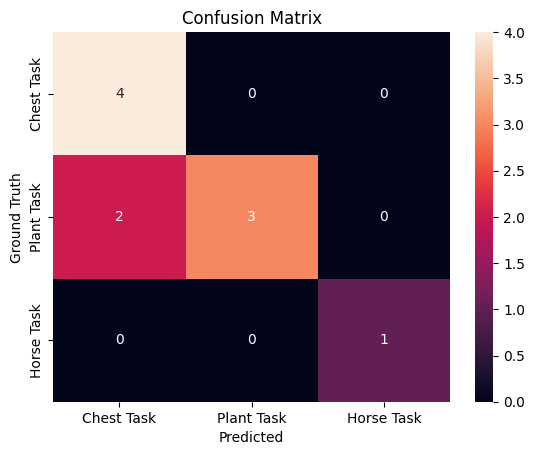

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

print(metrics)
# Just plotting for easier read
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted');ax.set_ylabel('Ground Truth'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Chest Task', 'Plant Task', 'Horse Task']); ax.yaxis.set_ticklabels(['Chest Task', 'Plant Task', 'Horse Task']);

In [25]:
# Saving model
trainer.model.save_pretrained("malmoTextClassifier")